### 1. Предобработка данных

In [2]:
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, MinMaxScaler
from category_encoders.binary import BinaryEncoder
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
from sklearn.feature_selection import VarianceThreshold

In [4]:
file_path = 'data.tsv'
df_base = pd.read_csv(file_path, sep='\t')
df = df_base.copy()

In [5]:
df.head()

,Production_series,Optical_power,Price_rub,MKL_Diameter_mm,Manufacturer,Manufacture_country,Brand,Lens_type,Moisture_content_%,Oxygen_transmission_Dk/t,Package_quantity_pieces,Replacement_period,Wearing_mode,Curvature_radius,Refractive_range,Material
0,acuvue oasys with hydraclear plus,-1.00,1680,14.0,johnson&johnson,сша/ирландия,acuvue,прозрачные,38.0,147.0,6,две недели,дневной; допускается непрерывное ношение до 7 ...,8.4; 8.8,от -12.0d до +8.0d,силикон-гидрогель
1,air optix plus hydraglyde,-1.00,1380,14.2,alcon,малайзия/индонезия,airoptix,прозрачные,33.0,138.0,3,один месяц,дневной; допускается непрерывное ношение до 6 ...,8.6,от -12.0d до +8.0d,силикон-гидрогель
2,total30,-1.00,2120,NaN,alcon,германия,total,прозрачные,55.0,154.0,3,один месяц,дневной,8.4,от -12.0d до +6.0d,водоградиентный
3,precision1 for astigmatism,-1.25,2580,14.5,alcon,германия,precision,астигматические,87.0,90.0,30,один день,дневной,8.5,от -8.0d до +4.0d,силикон-гидрогель
4,total30 for astigmatism,-1.00,2580,NaN,alcon,германия,total,астигматические,55.0,123.0,3,один месяц,дневной,8.6,от -8.0d до +4.0d,водоградиентный


In [8]:
# Удалим дубликаты записей, если они присутствуют
df = df.drop_duplicates()

In [10]:
df.shape

(4064, 16)

#### Обработка целевого признака и подсчет дисбаланса классов

In [13]:
target_column = 'Package_quantity_pieces'

In [15]:
df[target_column].unique()

array([  6,   3,  30,  90,  12,  24, 180,   4,   2,   1])

In [16]:
df[target_column] = np.where(df[target_column].isin([1, 2, 4, 3, 6]), 0, 1)

In [19]:
df[target_column].value_counts()

Package_quantity_pieces
0    2032
1    2032
Name: count, dtype: int64

In [20]:
# посчитаем дисбаланс классов
total = df.shape[0]
class_0, class_1 = df[target_column].value_counts()
print(f'Класс 0 составляет {round(class_0 / total, 4)*100}%,\n класс 1 составляет {round(class_1 / total, 4)*100}%')

Класс 0 составляет 50.0%,
 класс 1 составляет 50.0%


In [23]:
df.insert(0, 'Package_quantity_pieces', df.pop(target_column))

In [24]:
df.head()

,Package_quantity_pieces,Production_series,Optical_power,Price_rub,MKL_Diameter_mm,Manufacturer,Manufacture_country,Brand,Lens_type,Moisture_content_%,Oxygen_transmission_Dk/t,Replacement_period,Wearing_mode,Curvature_radius,Refractive_range,Material
0,0,acuvue oasys with hydraclear plus,-1.00,1680,14.0,johnson&johnson,сша/ирландия,acuvue,прозрачные,38.0,147.0,две недели,дневной; допускается непрерывное ношение до 7 ...,8.4; 8.8,от -12.0d до +8.0d,силикон-гидрогель
1,0,air optix plus hydraglyde,-1.00,1380,14.2,alcon,малайзия/индонезия,airoptix,прозрачные,33.0,138.0,один месяц,дневной; допускается непрерывное ношение до 6 ...,8.6,от -12.0d до +8.0d,силикон-гидрогель
2,0,total30,-1.00,2120,NaN,alcon,германия,total,прозрачные,55.0,154.0,один месяц,дневной,8.4,от -12.0d до +6.0d,водоградиентный
3,1,precision1 for astigmatism,-1.25,2580,14.5,alcon,германия,precision,астигматические,87.0,90.0,один день,дневной,8.5,от -8.0d до +4.0d,силикон-гидрогель
4,0,total30 for astigmatism,-1.00,2580,NaN,alcon,германия,total,астигматические,55.0,123.0,один месяц,дневной,8.6,от -8.0d до +4.0d,водоградиентный


##### Вывод. Дисбаланс классов отсутствует.

#### Обработка пропусков

In [29]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4064 entries, 0 to 51380
Data columns (total 16 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Package_quantity_pieces   4064 non-null   int64  
 1   Production_series         4064 non-null   object 
 2   Optical_power             4063 non-null   float64
 3   Price_rub                 4064 non-null   int64  
 4   MKL_Diameter_mm           3682 non-null   float64
 5   Manufacturer              4064 non-null   object 
 6   Manufacture_country       4064 non-null   object 
 7   Brand                     4064 non-null   object 
 8   Lens_type                 4064 non-null   object 
 9   Moisture_content_%        4064 non-null   float64
 10  Oxygen_transmission_Dk/t  4064 non-null   float64
 11  Replacement_period        4064 non-null   object 
 12  Wearing_mode              4064 non-null   object 
 13  Curvature_radius          4064 non-null   object 
 14  Refractive_r

In [31]:
df.describe()

,Package_quantity_pieces,Optical_power,Price_rub,MKL_Diameter_mm,Moisture_content_%,Oxygen_transmission_Dk/t
count,4064.000000,4063.000000,4064.000000,3682.000000,4064.000000,4064.000000
mean,0.500000,-1.850172,2894.542323,14.190521,52.115896,97.389673
std,0.500062,5.037167,1731.180177,0.156068,14.342638,51.421193
min,0.000000,-20.000000,910.000000,13.800000,24.000000,14.200000
25%,0.000000,-5.250000,1950.000000,14.100000,38.000000,41.500000
50%,0.500000,-2.000000,2430.000000,14.200000,55.000000,108.000000
75%,1.000000,2.000000,3140.000000,14.200000,58.000000,143.250000
max,1.000000,20.000000,12360.000000,14.500000,87.000000,175.000000


In [33]:
df.isnull().sum()

Package_quantity_pieces       0
Production_series             0
Optical_power                 1
Price_rub                     0
MKL_Diameter_mm             382
Manufacturer                  0
Manufacture_country           0
Brand                         0
Lens_type                     0
Moisture_content_%            0
Oxygen_transmission_Dk/t      0
Replacement_period            0
Wearing_mode                  0
Curvature_radius              0
Refractive_range            267
Material                      0
dtype: int64

In [34]:
for col in df.columns:
    print(f'{col}: {df[col].isna().sum() / df.shape[0] * 100:.2f}%')

Package_quantity_pieces: 0.00%
Production_series: 0.00%
Optical_power: 0.02%
Price_rub: 0.00%
MKL_Diameter_mm: 9.40%
Manufacturer: 0.00%
Manufacture_country: 0.00%
Brand: 0.00%
Lens_type: 0.00%
Moisture_content_%: 0.00%
Oxygen_transmission_Dk/t: 0.00%
Replacement_period: 0.00%
Wearing_mode: 0.00%
Curvature_radius: 0.00%
Refractive_range: 6.57%
Material: 0.00%


In [36]:
df.shape

(4064, 16)

##### Количественные признаки

In [39]:
df['Optical_power'].value_counts()

Optical_power
-1.5     83
-4.5     83
-3.5     81
-5.5     81
-3.0     81
         ..
 10.5     1
 18.0     1
 17.0     1
 20.0     1
-17.5     1
Name: count, Length: 111, dtype: int64

In [42]:
df.dropna(subset=['Optical_power'], axis=0, inplace=True)
df.shape

(4063, 16)

##### Качественные признаки

In [45]:
df['MKL_Diameter_mm'].value_counts()

MKL_Diameter_mm
14.2    1720
14.0     815
14.5     493
14.1     317
14.3     293
13.8      43
Name: count, dtype: int64

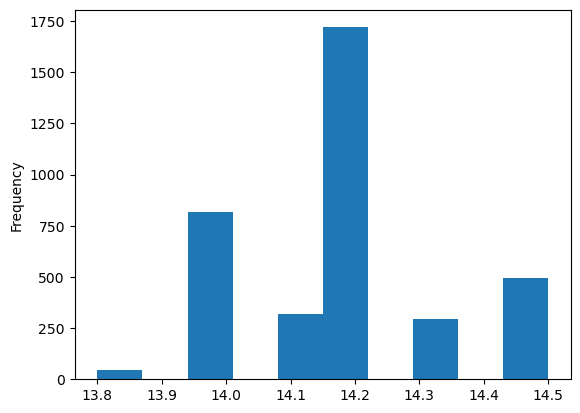

In [46]:
df['MKL_Diameter_mm'].plot(kind='hist', bins=10);

In [48]:
df['MKL_Diameter_mm'].mode()

0    14.2
Name: MKL_Diameter_mm, dtype: float64

In [49]:
df['MKL_Diameter_mm'].fillna(df['MKL_Diameter_mm'].mode().iloc[0], inplace=True)

In [50]:
# df['Refractive_range'].fillna('нет данных', inplace=True)

##### Удаление ненужных признаков

In [52]:
df.drop(['Refractive_range', 'Wearing_mode', 'Production_series', 'Curvature_radius', 'Manufacture_country'], axis=1, inplace=True)
df.head()

,Package_quantity_pieces,Optical_power,Price_rub,MKL_Diameter_mm,Manufacturer,Brand,Lens_type,Moisture_content_%,Oxygen_transmission_Dk/t,Replacement_period,Material
0,0,-1.00,1680,14.0,johnson&johnson,acuvue,прозрачные,38.0,147.0,две недели,силикон-гидрогель
1,0,-1.00,1380,14.2,alcon,airoptix,прозрачные,33.0,138.0,один месяц,силикон-гидрогель
2,0,-1.00,2120,14.2,alcon,total,прозрачные,55.0,154.0,один месяц,водоградиентный
3,1,-1.25,2580,14.5,alcon,precision,астигматические,87.0,90.0,один день,силикон-гидрогель
4,0,-1.00,2580,14.2,alcon,total,астигматические,55.0,123.0,один месяц,водоградиентный


In [58]:
df.isnull().sum()

Package_quantity_pieces     0
Optical_power               0
Price_rub                   0
MKL_Diameter_mm             0
Manufacturer                0
Brand                       0
Lens_type                   0
Moisture_content_%          0
Oxygen_transmission_Dk/t    0
Replacement_period          0
Material                    0
dtype: int64

In [59]:
df.shape

(4063, 11)

In [60]:
df.columns

Index(['Package_quantity_pieces', 'Optical_power', 'Price_rub',
       'MKL_Diameter_mm', 'Manufacturer', 'Brand', 'Lens_type',
       'Moisture_content_%', 'Oxygen_transmission_Dk/t', 'Replacement_period',
       'Material'],
      dtype='object')

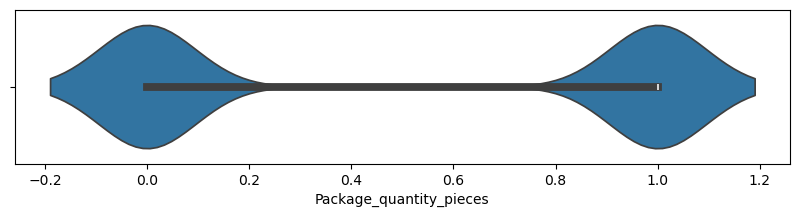

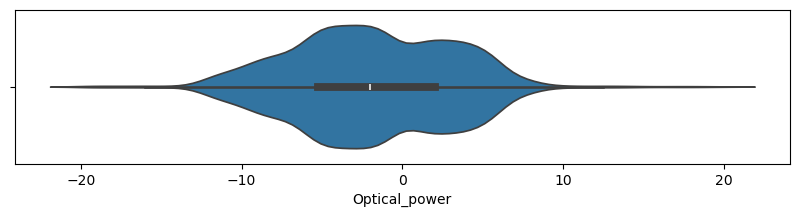

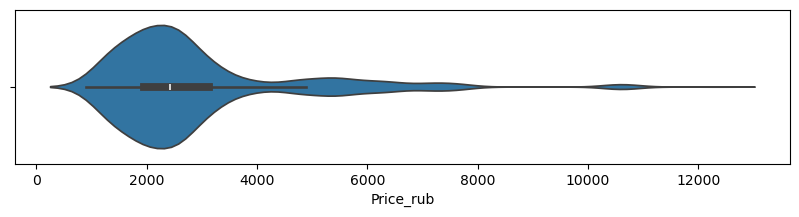

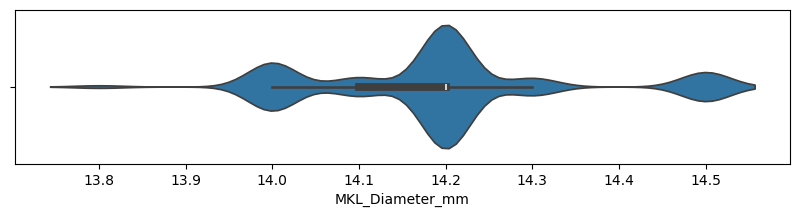

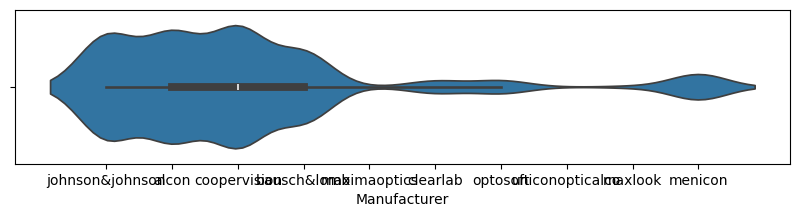

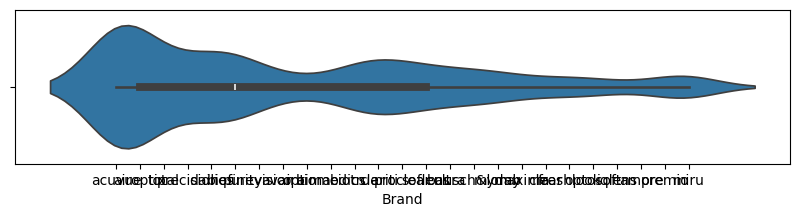

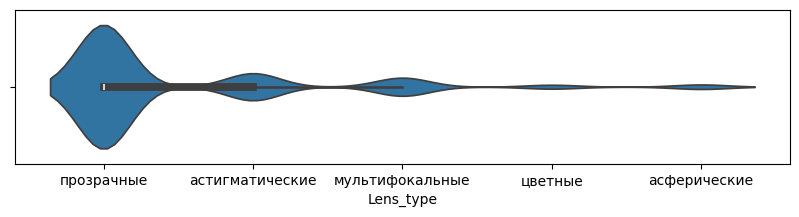

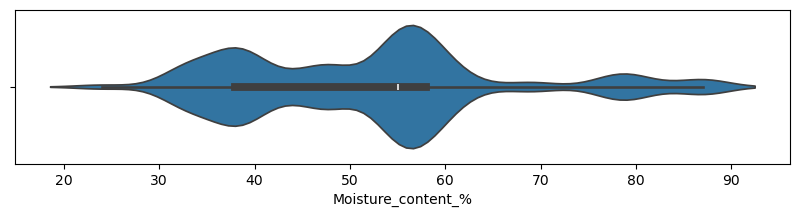

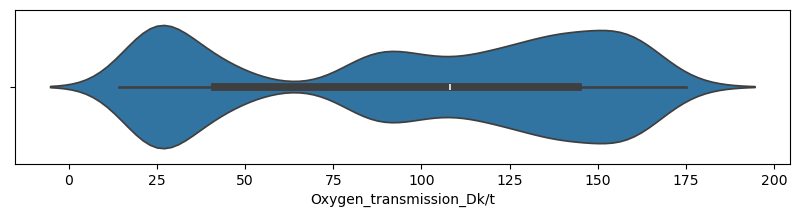

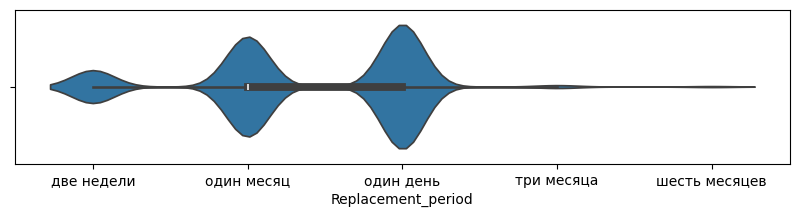

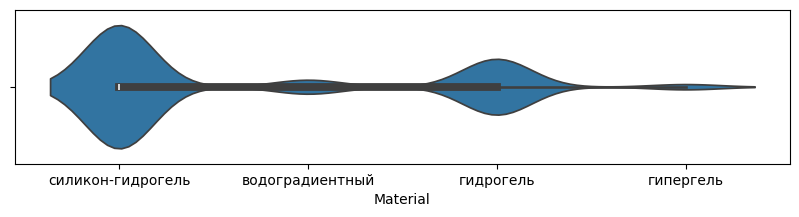

In [61]:
for col in df.columns:
    plt.figure(figsize=(10, 2))
    sns.violinplot(x=df[col])
    plt.show()

#### Преобразование нецелевых категорий

##### One-hot Encoding

In [67]:
# Replacement_period
# Инициализируем OneHotEncoder
encoder = OneHotEncoder(sparse_output = False)

# Преобразуем столбец 'Replacement_period'
onehot_columns = encoder.fit_transform(df[['Replacement_period']])

# Создаем датафрейм с новыми столбцами
encoded_df = pd.DataFrame(onehot_columns, columns=encoder.get_feature_names_out(['Replacement_period']))

encoded_columns_name = encoder.get_feature_names_out(['Replacement_period'])
df.reset_index(drop=True, inplace=True)
encoded_df.reset_index(drop=True, inplace=True)

df = pd.concat([df, encoded_df], axis=1)

df.drop('Replacement_period', axis = 1, inplace = True)
df.head()

,Package_quantity_pieces,Optical_power,Price_rub,MKL_Diameter_mm,Manufacturer,Brand,Lens_type,Moisture_content_%,Oxygen_transmission_Dk/t,Material,Replacement_period_две недели,Replacement_period_один день,Replacement_period_один месяц,Replacement_period_три месяца,Replacement_period_шесть месяцев
0,0,-1.00,1680,14.0,johnson&johnson,acuvue,прозрачные,38.0,147.0,силикон-гидрогель,1.0,0.0,0.0,0.0,0.0
1,0,-1.00,1380,14.2,alcon,airoptix,прозрачные,33.0,138.0,силикон-гидрогель,0.0,0.0,1.0,0.0,0.0
2,0,-1.00,2120,14.2,alcon,total,прозрачные,55.0,154.0,водоградиентный,0.0,0.0,1.0,0.0,0.0
3,1,-1.25,2580,14.5,alcon,precision,астигматические,87.0,90.0,силикон-гидрогель,0.0,1.0,0.0,0.0,0.0
4,0,-1.00,2580,14.2,alcon,total,астигматические,55.0,123.0,водоградиентный,0.0,0.0,1.0,0.0,0.0


In [68]:
# Lens_type
# Инициализируем OneHotEncoder
encoder = OneHotEncoder(sparse_output = False)

# Преобразуем столбец 'Lens_type'
onehot_columns = encoder.fit_transform(df[['Lens_type']])

# Создаем датафрейм с новыми столбцами
encoded_df = pd.DataFrame(onehot_columns, columns=encoder.get_feature_names_out(['Lens_type']))

encoded_columns_name = encoder.get_feature_names_out(['Lens_type'])
df.reset_index(drop=True, inplace=True)
encoded_df.reset_index(drop=True, inplace=True)

df = pd.concat([df, encoded_df], axis=1)

df.drop('Lens_type', axis = 1, inplace = True)
df.head()

,Package_quantity_pieces,Optical_power,Price_rub,MKL_Diameter_mm,Manufacturer,Brand,Moisture_content_%,Oxygen_transmission_Dk/t,Material,Replacement_period_две недели,Replacement_period_один день,Replacement_period_один месяц,Replacement_period_три месяца,Replacement_period_шесть месяцев,Lens_type_астигматические,Lens_type_асферические,Lens_type_мультифокальные,Lens_type_прозрачные,Lens_type_цветные
0,0,-1.00,1680,14.0,johnson&johnson,acuvue,38.0,147.0,силикон-гидрогель,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0,-1.00,1380,14.2,alcon,airoptix,33.0,138.0,силикон-гидрогель,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0,-1.00,2120,14.2,alcon,total,55.0,154.0,водоградиентный,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,1,-1.25,2580,14.5,alcon,precision,87.0,90.0,силикон-гидрогель,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,0,-1.00,2580,14.2,alcon,total,55.0,123.0,водоградиентный,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [69]:
# Manufacturer
# Инициализируем OneHotEncoder
encoder = OneHotEncoder(sparse_output = False)

# Преобразуем столбец 'Manufacturer'
onehot_columns = encoder.fit_transform(df[['Manufacturer']])

# Создаем датафрейм с новыми столбцами
encoded_df = pd.DataFrame(onehot_columns, columns=encoder.get_feature_names_out(['Manufacturer']))

encoded_columns_name = encoder.get_feature_names_out(['Manufacturer'])
df = pd.concat([df, encoded_df], axis=1)

df.drop('Manufacturer', axis = 1, inplace = True)
df.head()

,Package_quantity_pieces,Optical_power,Price_rub,MKL_Diameter_mm,Brand,Moisture_content_%,Oxygen_transmission_Dk/t,Material,Replacement_period_две недели,Replacement_period_один день,...,Manufacturer_alcon,Manufacturer_bausch&lomb,Manufacturer_clearlab,Manufacturer_coopervision,Manufacturer_johnson&johnson,Manufacturer_maximaoptics,Manufacturer_maxlook,Manufacturer_menicon,Manufacturer_optosoft,Manufacturer_uniconopticalco
0,0,-1.00,1680,14.0,acuvue,38.0,147.0,силикон-гидрогель,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,0,-1.00,1380,14.2,airoptix,33.0,138.0,силикон-гидрогель,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0,-1.00,2120,14.2,total,55.0,154.0,водоградиентный,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1,-1.25,2580,14.5,precision,87.0,90.0,силикон-гидрогель,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0,-1.00,2580,14.2,total,55.0,123.0,водоградиентный,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [70]:
# Material
# Инициализируем OneHotEncoder
encoder = OneHotEncoder(sparse_output = False)

# Преобразуем столбец 'Material'
onehot_columns = encoder.fit_transform(df[['Material']])

# Создаем датафрейм с новыми столбцами
encoded_df = pd.DataFrame(onehot_columns, columns=encoder.get_feature_names_out(['Material']))

encoded_columns_name = encoder.get_feature_names_out(['Material'])
df = pd.concat([df, encoded_df], axis=1)

df.drop('Material', axis = 1, inplace = True)
df.head()

,Package_quantity_pieces,Optical_power,Price_rub,MKL_Diameter_mm,Brand,Moisture_content_%,Oxygen_transmission_Dk/t,Replacement_period_две недели,Replacement_period_один день,Replacement_period_один месяц,...,Manufacturer_johnson&johnson,Manufacturer_maximaoptics,Manufacturer_maxlook,Manufacturer_menicon,Manufacturer_optosoft,Manufacturer_uniconopticalco,Material_водоградиентный,Material_гидрогель,Material_гипергель,Material_силикон-гидрогель
0,0,-1.00,1680,14.0,acuvue,38.0,147.0,1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,0,-1.00,1380,14.2,airoptix,33.0,138.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0,-1.00,2120,14.2,total,55.0,154.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,1,-1.25,2580,14.5,precision,87.0,90.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,0,-1.00,2580,14.2,total,55.0,123.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [71]:
# Brand
# Инициализируем OneHotEncoder
encoder = OneHotEncoder(sparse_output = False)

# Преобразуем столбец 'Brand'
onehot_columns = encoder.fit_transform(df[['Brand']])

# Создаем датафрейм с новыми столбцами
encoded_df = pd.DataFrame(onehot_columns, columns=encoder.get_feature_names_out(['Brand']))

encoded_columns_name = encoder.get_feature_names_out(['Brand'])
df = pd.concat([df, encoded_df], axis=1)

df.drop('Brand', axis = 1, inplace = True)
df.head()

,Package_quantity_pieces,Optical_power,Price_rub,MKL_Diameter_mm,Moisture_content_%,Oxygen_transmission_Dk/t,Replacement_period_две недели,Replacement_period_один день,Replacement_period_один месяц,Replacement_period_три месяца,...,Brand_myday,Brand_optima,Brand_optosoft,Brand_precision,Brand_premio,Brand_proclear,Brand_purevision,Brand_soflens,Brand_total,Brand_ultra
0,0,-1.00,1680,14.0,38.0,147.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0,-1.00,1380,14.2,33.0,138.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0,-1.00,2120,14.2,55.0,154.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,1,-1.25,2580,14.5,87.0,90.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0,-1.00,2580,14.2,55.0,123.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [72]:
df.shape

(4063, 55)

#### Масштабирование признаков

In [74]:
# Числовые колонки для масштабирования
scale_cols = ['Price_rub', 'MKL_Diameter_mm', 'Moisture_content_%', 'Oxygen_transmission_Dk/t', 'Optical_power']

In [75]:
scaler = MinMaxScaler()
scaler_data = scaler.fit_transform(df[scale_cols])

In [76]:
# Добавим масштабированные данные в набор данных
for i in range(len(scale_cols)):
    col = scale_cols[i]
    new_col_name = col + '_scaled'
    df[new_col_name] = scaler_data[:,i]

In [77]:
df.head()

,Package_quantity_pieces,Optical_power,Price_rub,MKL_Diameter_mm,Moisture_content_%,Oxygen_transmission_Dk/t,Replacement_period_две недели,Replacement_period_один день,Replacement_period_один месяц,Replacement_period_три месяца,...,Brand_proclear,Brand_purevision,Brand_soflens,Brand_total,Brand_ultra,Price_rub_scaled,MKL_Diameter_mm_scaled,Moisture_content_%_scaled,Oxygen_transmission_Dk/t_scaled,Optical_power_scaled
0,0,-1.00,1680,14.0,38.0,147.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.067249,0.285714,0.222222,0.825871,0.47500
1,0,-1.00,1380,14.2,33.0,138.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.041048,0.571429,0.142857,0.769900,0.47500
2,0,-1.00,2120,14.2,55.0,154.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.105677,0.571429,0.492063,0.869403,0.47500
3,1,-1.25,2580,14.5,87.0,90.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.145852,1.000000,1.000000,0.471393,0.46875
4,0,-1.00,2580,14.2,55.0,123.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.145852,0.571429,0.492063,0.676617,0.47500


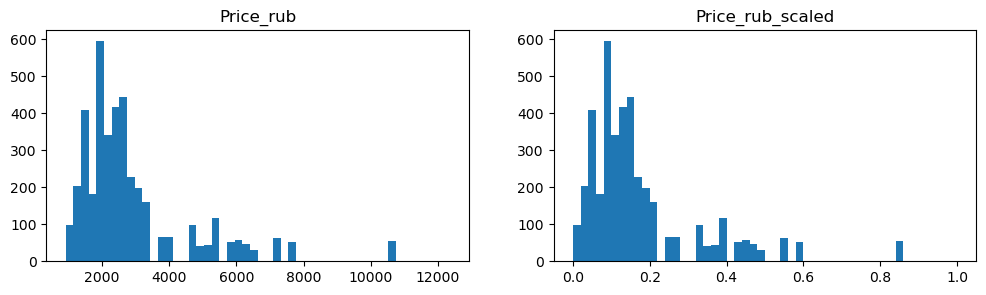

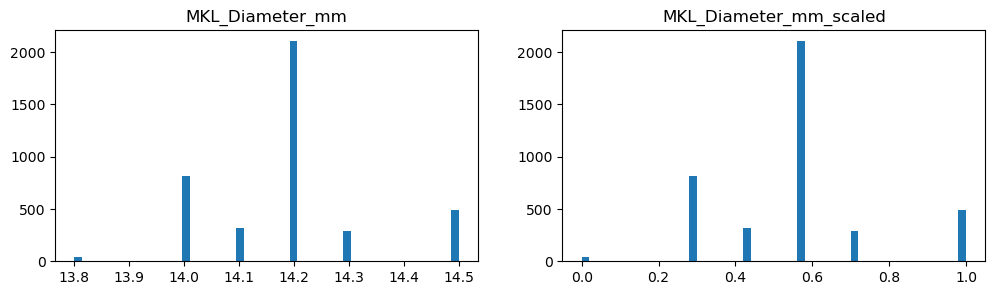

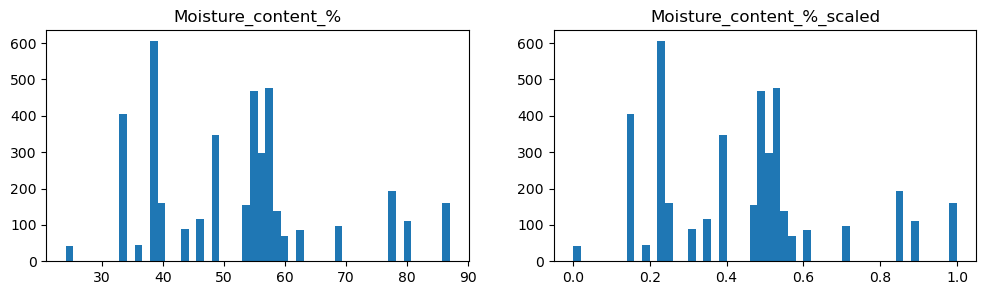

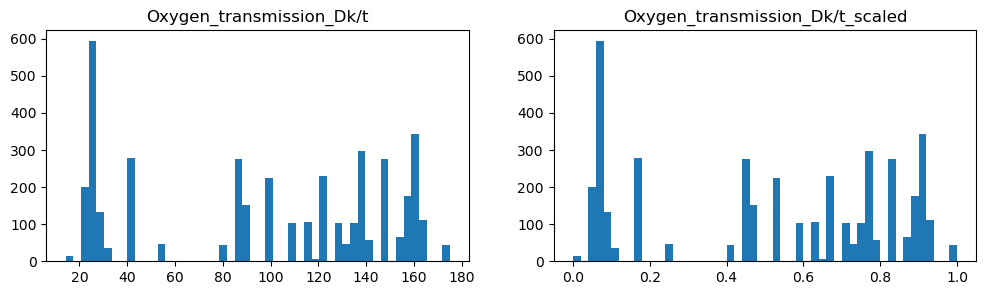

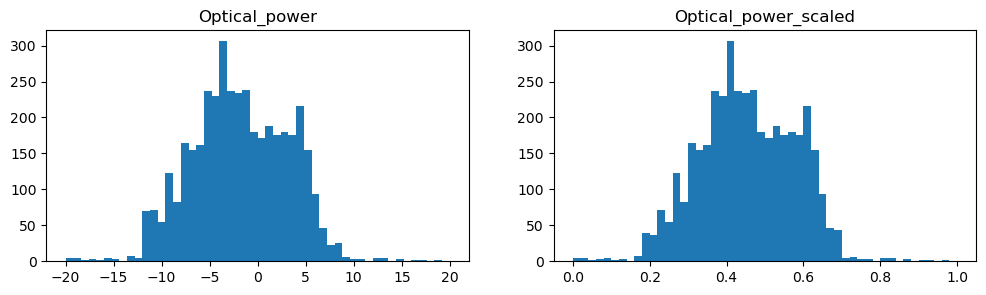

In [78]:
# Проверим, что масштабирование не повлияло на распределение данных
for col in scale_cols:
    col_scaled = col + '_scaled'

    fig, ax = plt.subplots(1, 2, figsize=(12,3))
    ax[0].hist(df[col], 50)
    ax[1].hist(df[col_scaled], 50)
    ax[0].title.set_text(col)
    ax[1].title.set_text(col_scaled)
    plt.show()

In [79]:
df.drop(columns=scale_cols, axis = 1, inplace = True)

#### Отбор признаков

##### Удаление константных и псевдоконстантных (почти константных) признаков

In [82]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4063 entries, 0 to 4062
Data columns (total 55 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Package_quantity_pieces           4063 non-null   int64  
 1   Replacement_period_две недели     4063 non-null   float64
 2   Replacement_period_один день      4063 non-null   float64
 3   Replacement_period_один месяц     4063 non-null   float64
 4   Replacement_period_три месяца     4063 non-null   float64
 5   Replacement_period_шесть месяцев  4063 non-null   float64
 6   Lens_type_астигматические         4063 non-null   float64
 7   Lens_type_асферические            4063 non-null   float64
 8   Lens_type_мультифокальные         4063 non-null   float64
 9   Lens_type_прозрачные              4063 non-null   float64
 10  Lens_type_цветные                 4063 non-null   float64
 11  Manufacturer_alcon                4063 non-null   float64
 12  Manufa

In [83]:
X = df.drop(columns=['Package_quantity_pieces'])
selector = VarianceThreshold(threshold=0.015)
selector.fit(X)
# Значения дисперсий для каждого признака
variances = selector.variances_
for var in variances:
    print(f"{var:.2f}")

0.11
0.25
0.24
0.01
0.00
0.13
0.02
0.09
0.21
0.02
0.18
0.13
0.03
0.19
0.18
0.00
0.00
0.06
0.03
0.00
0.07
0.20
0.03
0.24
0.18
0.09
0.00
0.03
0.02
0.08
0.01
0.05
0.06
0.03
0.06
0.00
0.00
0.00
0.04
0.04
0.01
0.03
0.04
0.01
0.03
0.01
0.04
0.03
0.03
0.02
0.05
0.05
0.10
0.02


In [84]:
X.head()

,Replacement_period_две недели,Replacement_period_один день,Replacement_period_один месяц,Replacement_period_три месяца,Replacement_period_шесть месяцев,Lens_type_астигматические,Lens_type_асферические,Lens_type_мультифокальные,Lens_type_прозрачные,Lens_type_цветные,...,Brand_proclear,Brand_purevision,Brand_soflens,Brand_total,Brand_ultra,Price_rub_scaled,MKL_Diameter_mm_scaled,Moisture_content_%_scaled,Oxygen_transmission_Dk/t_scaled,Optical_power_scaled
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.067249,0.285714,0.222222,0.825871,0.47500
1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.041048,0.571429,0.142857,0.769900,0.47500
2,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.105677,0.571429,0.492063,0.869403,0.47500
3,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.145852,1.000000,1.000000,0.471393,0.46875
4,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.145852,0.571429,0.492063,0.676617,0.47500


In [85]:
# Константный и псевдоконстантный признаки удалены
selector.transform(X)

array([[1.        , 0.        , 0.        , ..., 0.22222222, 0.82587065,
        0.475     ],
       [0.        , 0.        , 1.        , ..., 0.14285714, 0.7699005 ,
        0.475     ],
       [0.        , 0.        , 1.        , ..., 0.49206349, 0.86940299,
        0.475     ],
       ...,
       [0.        , 0.        , 1.        , ..., 0.25396825, 0.91293532,
        0.325     ],
       [0.        , 0.        , 1.        , ..., 0.25396825, 0.91293532,
        0.4       ],
       [0.        , 0.        , 1.        , ..., 0.25396825, 0.91293532,
        0.6       ]])

In [97]:
mask = selector.get_support()

In [98]:
selected_columns = X.columns[mask]
selected_columns

Index(['Replacement_period_две недели', 'Replacement_period_один день',
       'Replacement_period_один месяц', 'Lens_type_астигматические',
       'Lens_type_асферические', 'Lens_type_мультифокальные',
       'Lens_type_прозрачные', 'Lens_type_цветные', 'Manufacturer_alcon',
       'Manufacturer_bausch&lomb', 'Manufacturer_clearlab',
       'Manufacturer_coopervision', 'Manufacturer_johnson&johnson',
       'Manufacturer_menicon', 'Manufacturer_optosoft',
       'Material_водоградиентный', 'Material_гидрогель', 'Material_гипергель',
       'Material_силикон-гидрогель', 'Brand_acuvue', 'Brand_airoptix',
       'Brand_avaira', 'Brand_bausch&lomb', 'Brand_biofinity', 'Brand_biotruе',
       'Brand_clariti', 'Brand_clear', 'Brand_dailies', 'Brand_miru',
       'Brand_myday', 'Brand_optosoft', 'Brand_precision', 'Brand_proclear',
       'Brand_soflens', 'Brand_total', 'Brand_ultra', 'Price_rub_scaled',
       'MKL_Diameter_mm_scaled', 'Moisture_content_%_scaled',
       'Oxygen_transmissio

In [99]:
dropped_columns = X.columns[~mask]
dropped_columns

Index(['Replacement_period_три месяца', 'Replacement_period_шесть месяцев',
       'Manufacturer_maximaoptics', 'Manufacturer_maxlook',
       'Manufacturer_uniconopticalco', 'Brand_amore', 'Brand_biomedics',
       'Brand_freshlook', 'Brand_iqlens', 'Brand_maxima', 'Brand_optima',
       'Brand_premio', 'Brand_purevision'],
      dtype='object')

In [100]:
df.drop(columns = dropped_columns, axis = 1, inplace = True)

In [101]:
df.head()

,Package_quantity_pieces,Replacement_period_две недели,Replacement_period_один день,Replacement_period_один месяц,Lens_type_астигматические,Lens_type_асферические,Lens_type_мультифокальные,Lens_type_прозрачные,Lens_type_цветные,Manufacturer_alcon,...,Brand_precision,Brand_proclear,Brand_soflens,Brand_total,Brand_ultra,Price_rub_scaled,MKL_Diameter_mm_scaled,Moisture_content_%_scaled,Oxygen_transmission_Dk/t_scaled,Optical_power_scaled
0,0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.067249,0.285714,0.222222,0.825871,0.47500
1,0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.041048,0.571429,0.142857,0.769900,0.47500
2,0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.105677,0.571429,0.492063,0.869403,0.47500
3,1,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.145852,1.000000,1.000000,0.471393,0.46875
4,0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.145852,0.571429,0.492063,0.676617,0.47500


##### Удаление повторяющихся признаков

In [103]:
def get_duplicates(X):
    """
    Поиск дубликатов в колонках
    X - DataFrame
    """
    
    pairs = {}
    dups = []

    # Перебор всех колонок (внешний)
    for i in range(X.shape[1]):

        # текущая колонка
        feat_outer = X.columns[i]

        # если текущая колонка не является дублем
        if feat_outer not in dups:

            # создаем запись в словаре, колонка является ключом
            pairs[feat_outer] = []

            # Перебор оставшихся колонок (внутренний)
            for feat_inner in X.columns[i + 1:]:

                # Если колонки идентичны
                if X[feat_outer].equals(X[feat_inner]):

                    # добавление в словарь и список дубликатов
                    pairs[feat_outer].append(feat_inner)
                    dups.append(feat_inner)

    return pairs

In [104]:
get_duplicates(df)

{'Package_quantity_pieces': [],
 'Replacement_period_две недели': [],
 'Replacement_period_один день': [],
 'Replacement_period_один месяц': [],
 'Lens_type_астигматические': [],
 'Lens_type_асферические': [],
 'Lens_type_мультифокальные': [],
 'Lens_type_прозрачные': [],
 'Lens_type_цветные': [],
 'Manufacturer_alcon': [],
 'Manufacturer_bausch&lomb': [],
 'Manufacturer_clearlab': ['Brand_clear'],
 'Manufacturer_coopervision': [],
 'Manufacturer_johnson&johnson': ['Brand_acuvue'],
 'Manufacturer_menicon': [],
 'Manufacturer_optosoft': ['Brand_optosoft'],
 'Material_водоградиентный': [],
 'Material_гидрогель': [],
 'Material_гипергель': [],
 'Material_силикон-гидрогель': [],
 'Brand_airoptix': [],
 'Brand_avaira': [],
 'Brand_bausch&lomb': [],
 'Brand_biofinity': [],
 'Brand_biotruе': [],
 'Brand_clariti': [],
 'Brand_dailies': [],
 'Brand_miru': [],
 'Brand_myday': [],
 'Brand_precision': [],
 'Brand_proclear': [],
 'Brand_soflens': [],
 'Brand_total': [],
 'Brand_ultra': [],
 'Price_

In [105]:
dropped_columns = ['Brand_acuvue', 'Brand_clear', 'Brand_optosoft']
df.drop(columns = dropped_columns, axis = 1, inplace = True) 

##### Методы, основанные на корреляции

<Axes: >

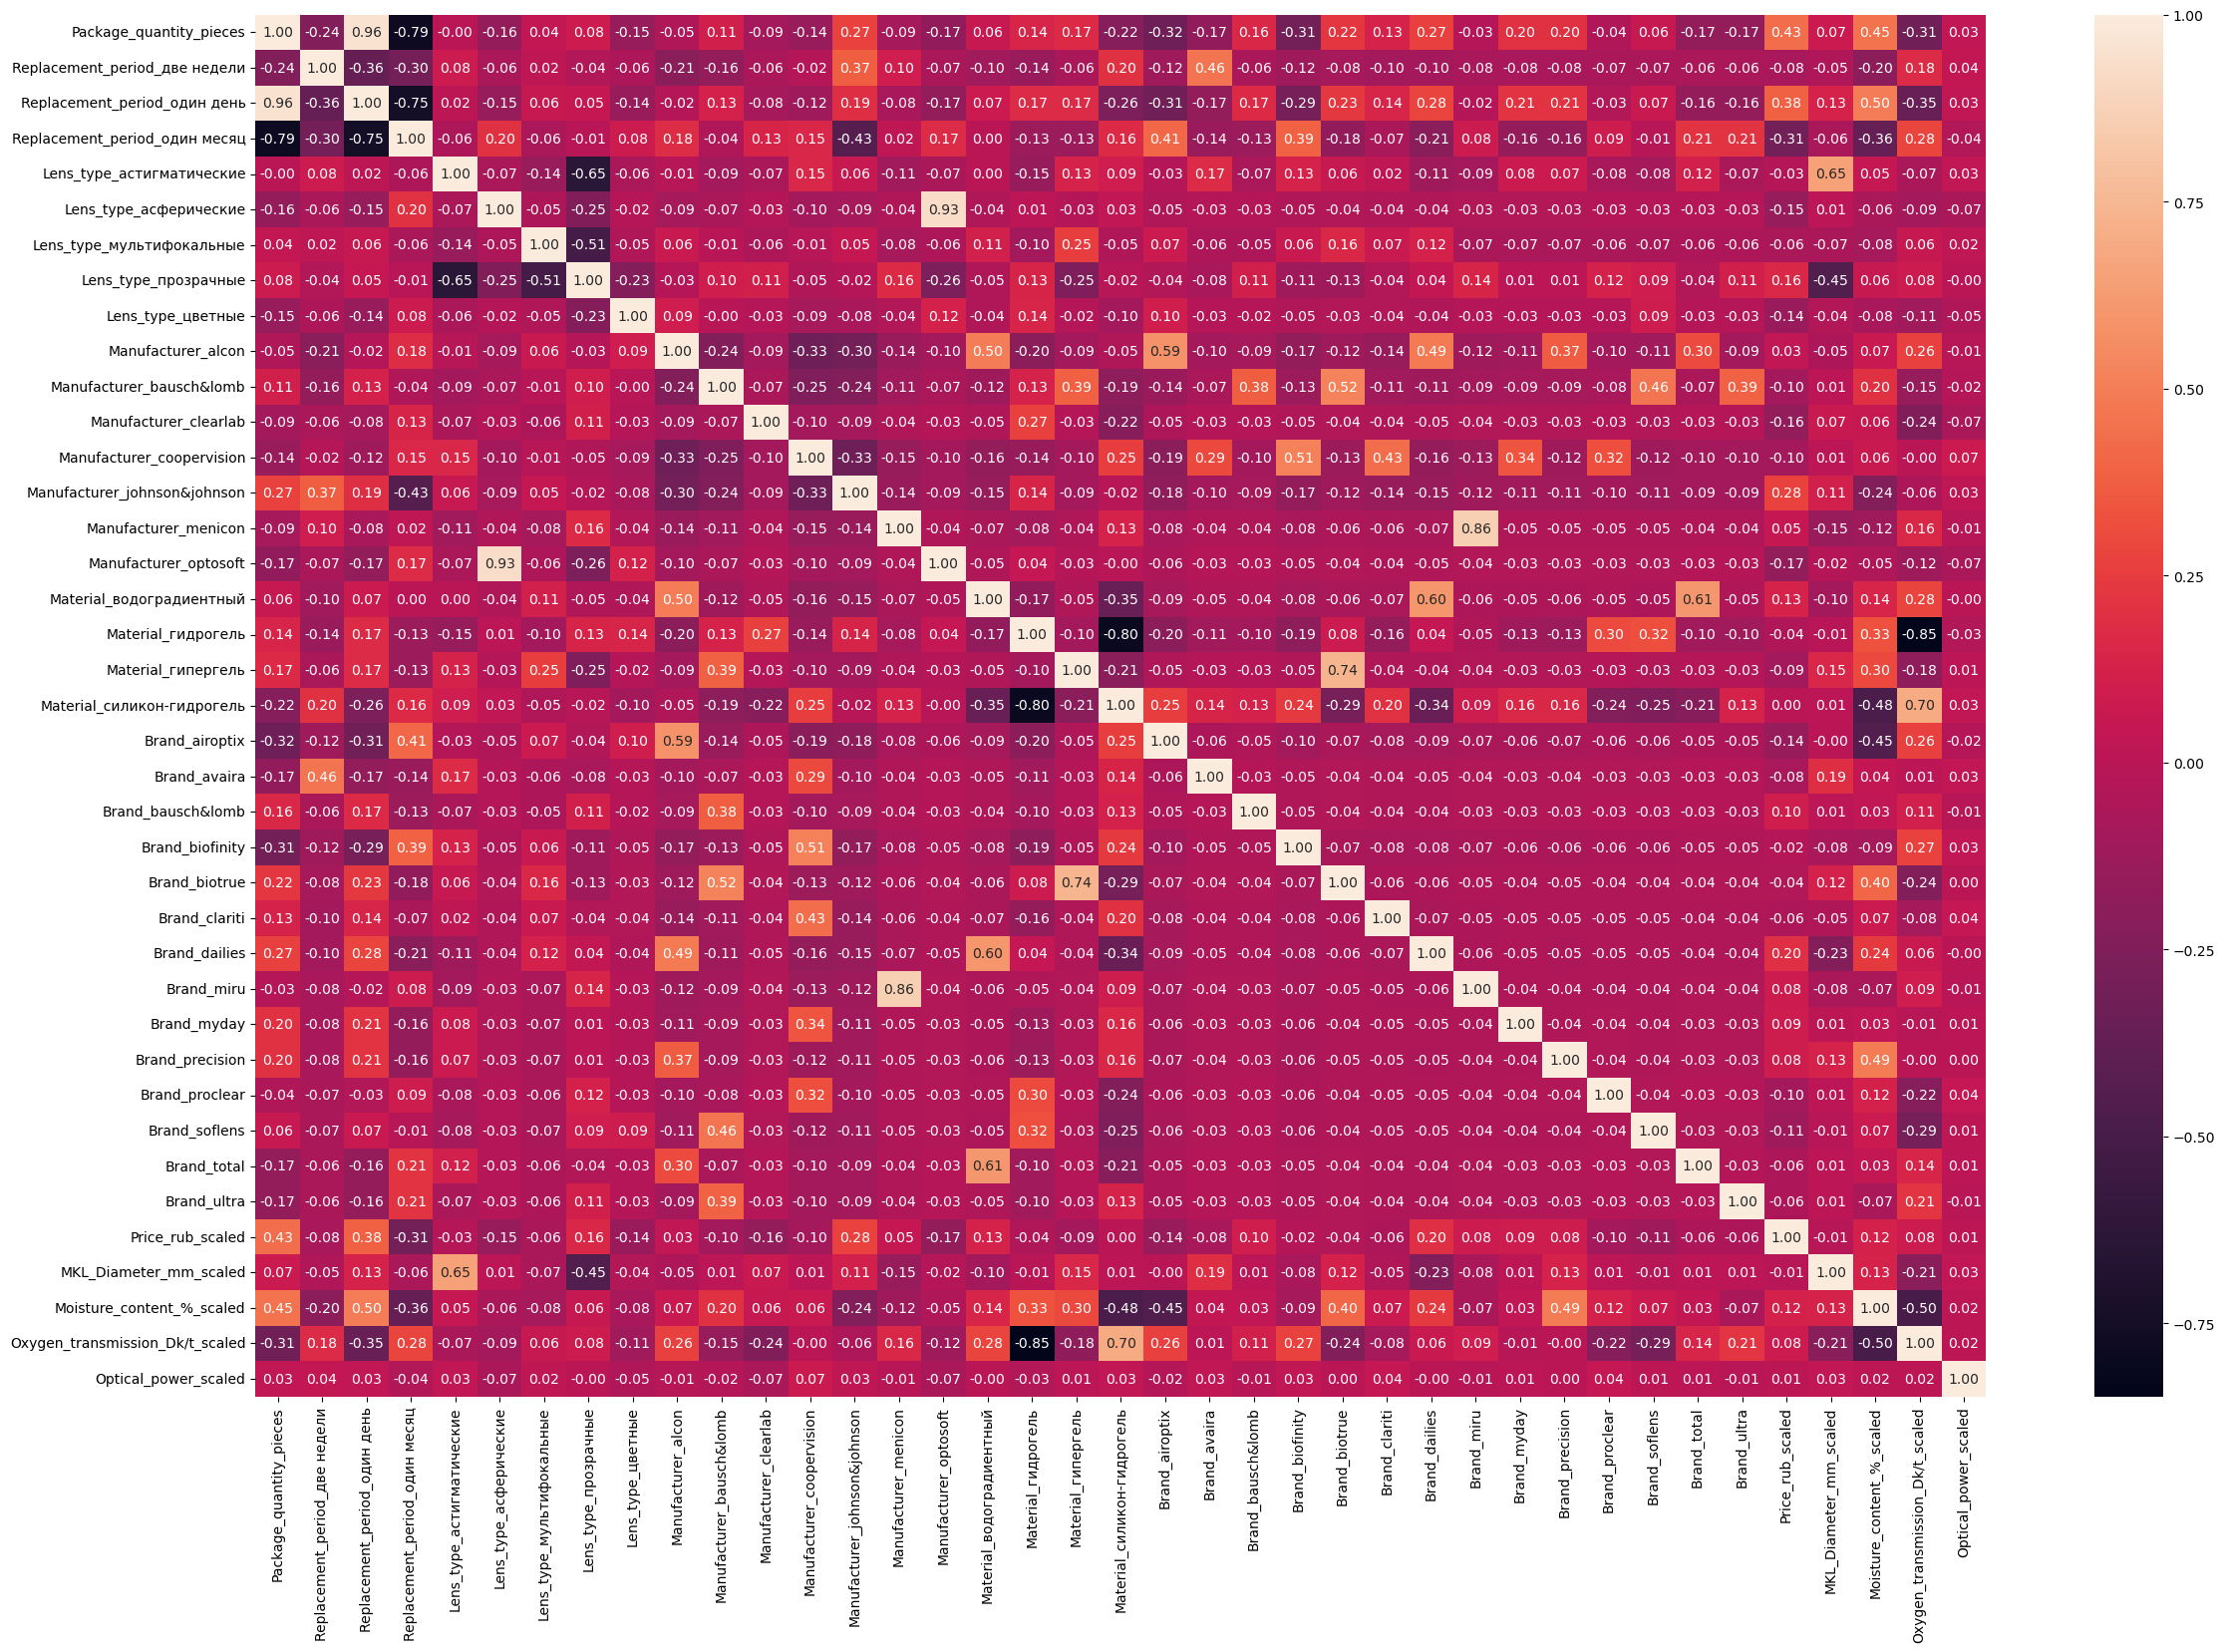

In [107]:
plt.figure(figsize=(28, 18))
sns.heatmap(df.corr(), annot=True, fmt='.2f')

In [114]:
# Формирование DataFrame с сильными корреляциями
def make_corr_df(df):
    cr = df.corr()
    cr = cr.abs().unstack() 
    cr = cr.sort_values(ascending=False)
    cr = cr[cr >= 0.8]
    cr = cr[cr < 1]
    cr = pd.DataFrame(cr).reset_index()
    cr.columns = ['f1', 'f2', 'corr']
    return cr

In [115]:
make_corr_df(df)

,f1,f2,corr
0,Replacement_period_один день,Package_quantity_pieces,0.955223
1,Package_quantity_pieces,Replacement_period_один день,0.955223
2,Manufacturer_optosoft,Lens_type_асферические,0.932510
3,Lens_type_асферические,Manufacturer_optosoft,0.932510
4,Brand_miru,Manufacturer_menicon,0.858108
5,Manufacturer_menicon,Brand_miru,0.858108
6,Material_гидрогель,Oxygen_transmission_Dk/t_scaled,0.847789
7,Oxygen_transmission_Dk/t_scaled,Material_гидрогель,0.847789
8,Material_силикон-гидрогель,Material_гидрогель,0.802068
9,Material_гидрогель,Material_силикон-гидрогель,0.802068


In [116]:
# Обнаружение групп коррелирующих признаков
def corr_groups(cr):
    grouped_feature_list = []
    correlated_groups = []

    for feature in cr['f1'].unique():
        if feature not in grouped_feature_list:
            # находим коррелирующие признаки
            correlated_block = cr[cr['f1'] == feature]
            cur_dups = list(correlated_block['f2'].unique()) + [feature]
            grouped_feature_list = grouped_feature_list + cur_dups
            correlated_groups.append(cur_dups)
    return correlated_groups

In [117]:
# Группы коррелирующих признаков
corr_groups(make_corr_df(df))

[['Package_quantity_pieces', 'Replacement_period_один день'],
 ['Lens_type_асферические', 'Manufacturer_optosoft'],
 ['Manufacturer_menicon', 'Brand_miru'],
 ['Oxygen_transmission_Dk/t_scaled',
  'Material_силикон-гидрогель',
  'Material_гидрогель']]

In [118]:
dropped_columns = ['Lens_type_асферические', 'Brand_miru', 'Material_силикон-гидрогель', 'Material_гидрогель']
df.drop(columns = dropped_columns, axis = 1, inplace = True) 

In [127]:
# Удалим дубликаты записей, если они присутствуют
df = df.drop_duplicates()
df.shape

(4063, 35)

In [128]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4063 entries, 0 to 4062
Data columns (total 35 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Package_quantity_pieces          4063 non-null   int64  
 1   Replacement_period_две недели    4063 non-null   float64
 2   Replacement_period_один день     4063 non-null   float64
 3   Replacement_period_один месяц    4063 non-null   float64
 4   Lens_type_астигматические        4063 non-null   float64
 5   Lens_type_мультифокальные        4063 non-null   float64
 6   Lens_type_прозрачные             4063 non-null   float64
 7   Lens_type_цветные                4063 non-null   float64
 8   Manufacturer_alcon               4063 non-null   float64
 9   Manufacturer_bausch&lomb         4063 non-null   float64
 10  Manufacturer_clearlab            4063 non-null   float64
 11  Manufacturer_coopervision        4063 non-null   float64
 12  Manufacturer_johnson

In [129]:
df['Package_quantity_pieces'].value_counts()

Package_quantity_pieces
1    2032
0    2031
Name: count, dtype: int64

### 2. Линейная классификация

In [131]:
from sklearn.model_selection import GridSearchCV, StratifiedKFold, train_test_split, cross_val_score, ParameterGrid, KFold
from sklearn.metrics import f1_score, accuracy_score, mean_squared_error, confusion_matrix, ConfusionMatrixDisplay, log_loss, hinge_loss
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.linear_model import LogisticRegression, Ridge
from scipy.stats import sem

#### 1) Алгоритм линейной регрессии в матричном виде с гребневой регуляризацией

In [133]:
# Преобразуем целевой признак для классификации
df_regression = df.copy()
y_regression = df_regression.Package_quantity_pieces
y_classification = np.where(df['Package_quantity_pieces'].isin([0]), -1, 1)
X = df_regression[df_regression.columns.difference(['Package_quantity_pieces'])]

##### Разделение выборки на обучающую и тестовую

In [135]:
# Разделим данные на тренировочную и тестовую выборку для задачи регрессии
X_train_1, X_test_1, y_train_reg, y_test_reg = train_test_split(X, y_regression, test_size=0.4, random_state=42)

# Разделим y_classification на тренировочную и тестовую выборки, соответствующие регрессии
y_train_class, y_test_class = train_test_split(y_classification, test_size=0.4, random_state=42)

print(X_train_1.shape, y_train_reg.shape)
print(X_test_1.shape, y_test_reg.shape)

print(X_train_1.shape, y_train_class.shape)
print(X_test_1.shape, y_test_class.shape)

(2437, 34) (2437,)
(1626, 34) (1626,)
(2437, 34) (2437,)
(1626, 34) (1626,)


In [136]:
#1. Реализация линейной регрессии с гребневой регуляризацией
def linear_regression_ridge(X, y, alpha):
    # Добавляем столбец единиц для свободного члена
    X = np.c_[np.ones(X.shape[0]), X]  # Добавляем единичный столбец для смещения (intercept)
    
    # Получаем количество признаков
    n, m = X.shape
    
    # Создаем единичную матрицу размера m x m
    I = np.eye(m)
    I[0, 0] = 0  # Не регуляризуем свободный член (он всегда равен 1)
    
    # Нормальное уравнение для нахождения коэффициентов с регуляризацией
    beta = np.linalg.inv(X.T.dot(X) + alpha * I).dot(X.T).dot(y)
    
    return beta

In [137]:
# 2. Подбор гиперпараметра alpha с кросс-валидацией на тренировочной выборке

param_grid = {'alpha': [10**(i * 0.1) for i in range(-50, 51)]}
kf = KFold(n_splits=5, shuffle=True, random_state=42)
best_alpha_1 = None
best_mse = float('inf')
best_beta_1 = None

for alpha in param_grid['alpha']:

    mse_folds = []
    
    for train_index, val_index in kf.split(X_train_1):
        X_train_fold, X_val_fold = X_train_1.iloc[train_index], X_train_1.iloc[val_index]
        y_train_fold, y_val_fold = y_train_reg.iloc[train_index], y_train_reg.iloc[val_index]
        
        # Обучаем модель для текущего значения alpha на каждой подвыборке
        beta = linear_regression_ridge(X_train_fold, y_train_fold, alpha)
        y_pred_val = np.c_[np.ones(X_val_fold.shape[0]), X_val_fold] @ beta
        val_mse = mean_squared_error(y_val_fold, y_pred_val)
        mse_folds.append(val_mse)
    
    # Средняя MSE по всем фолдам
    avg_mse = np.mean(mse_folds)
    
    # Обновляем лучший alpha, если найдено более низкое значение ошибки
    if avg_mse < best_mse:
        best_mse = avg_mse
        best_alpha_1 = alpha
        best_beta_1 = beta

print(f"Лучший параметр alpha для Ridge Regression: {best_alpha_1:.4f}")
# print(f"Лучший бета вектор: {best_beta_1}")

Лучший параметр alpha для Ridge Regression: 0.0631


In [138]:
# 3. Обучение Ridge Regression с оптимальным alpha на тренировочной выборке

beta_best_1 = linear_regression_ridge(X_train_1, y_train_reg, best_alpha_1)
y_pred_test_1 = np.c_[np.ones(X_test_1.shape[0]), X_test_1].dot(beta_best_1)
test_mse_1 = mean_squared_error(y_test_reg, y_pred_test_1)
print(f"Среднеквадратичная ошибка на тестовой выборке: {test_mse_1:.4f}")

Среднеквадратичная ошибка на тестовой выборке: 0.0150


In [139]:
# 4. Обучение Ridge модели для классификации на тренировочной выборке

beta_class = linear_regression_ridge(X_train_1, y_train_class, best_alpha_1)

# Прогнозирование на тренировочной и тестовой выборке
train_predictions_1 = np.sign(np.c_[np.ones(X_train_1.shape[0]), X_train_1].dot(beta_class))
test_predictions_1 = np.sign(np.c_[np.ones(X_test_1.shape[0]), X_test_1].dot(beta_class))

train_loss_1 = hinge_loss(y_train_class, train_predictions_1)
test_loss_1 = hinge_loss(y_test_class, test_predictions_1)

print(f"Empirical risk на тренировочной выборке: {train_loss_1:.4f}")
print(f"Empirical risk на тестовой выборке: {test_loss_1:.4f}")

Empirical risk на тренировочной выборке: 0.0468
Empirical risk на тестовой выборке: 0.0443


In [146]:
# 5. Построение кривой обучения с доверительными интервалами
num_folds = 5
num_iterations = 200  # Число итераций для кривой обучения
kf = KFold(n_splits=num_folds, shuffle=True, random_state=42) # KFold для кросс-валидации
train_risks_per_split_1 = []
test_risks_per_split_1 = []

for train_index, test_index in kf.split(X_train_1):
    X_train_fold, X_val_fold = X_train_1.iloc[train_index], X_train_1.iloc[test_index]
    y_train_fold, y_val_fold = y_train_class[train_index], y_train_class[test_index]

    train_risks, test_risks = [], []

    for i in range(1, num_iterations + 1):
        beta = linear_regression_ridge(X_train_fold[:i], y_train_fold[:i], alpha=best_alpha_1)
    
        # Прогнозирование для тренировочной и тестовой выборки
        y_train_pred = np.c_[np.ones(X_train_fold[:i].shape[0]), X_train_fold[:i]] @ beta
        y_test_pred = np.c_[np.ones(X_val_fold.shape[0]), X_val_fold] @ beta
        
        # Вычисление эмпирического риска на тренировочной и тестовой выборках
        train_risk = hinge_loss(y_train_fold[:i], np.sign(y_train_pred))
        test_risk = hinge_loss(y_val_fold, np.sign(y_test_pred))
    
        train_risks.append(train_risk)
        test_risks.append(test_risk)

    train_risks_per_split_1.append(train_risks)
    test_risks_per_split_1.append(test_risks)


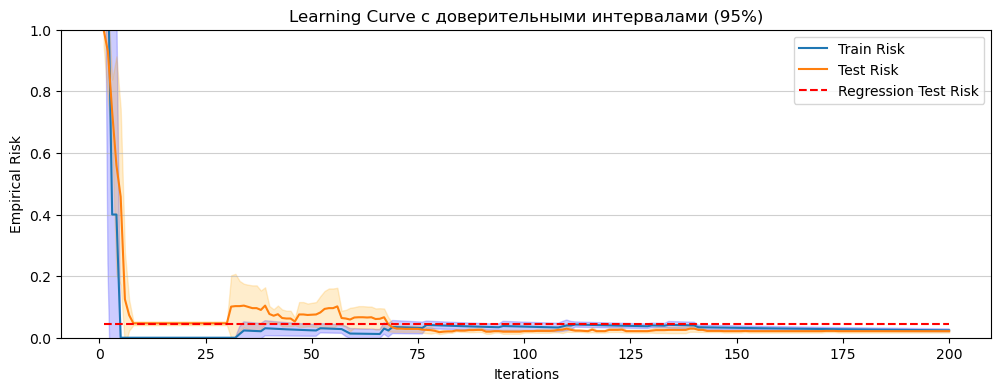

In [147]:
# 6. Вычисляем средние значения и доверительные интервалы
mean_train_risks_1 = np.mean(train_risks_per_split_1, axis=0)  # Средние значения потерь для тренировки
mean_test_risks_1 = np.mean(test_risks_per_split_1, axis=0) # Средние значения потерь для теста
std_err_train_1 = sem(train_risks_per_split_1, axis=0) # Стандартная ошибка для тренировочных рисков
std_err_test_1 = sem(test_risks_per_split_1, axis=0) # Стандартная ошибка для тестовых рисков

# Построение графиков с доверительным интервалом
plt.figure(figsize=(12, 4))

# Настройка осей
plt.ylim(0, 1)  # Установка пределов оси y
plt.yticks(np.arange(0, 1.1, 0.2))  # Установка шагов по оси y

# Для тренировочного эмпирического риска
plt.plot(range(1, num_iterations + 1), mean_train_risks_1, label="Train Risk")
plt.fill_between(
    range(1, num_iterations + 1),
    mean_train_risks_1 - 1.96 * std_err_train_1,  # Доверительный интервал для тренировки
    mean_train_risks_1 + 1.96 * std_err_train_1,
    alpha=0.2,
    color="blue"
)

# Для тестового эмпирического риска
plt.plot(range(1, num_iterations + 1), mean_test_risks_1, label="Test Risk")
plt.fill_between(
    range(1, num_iterations + 1),
    mean_test_risks_1 - 1.96 * std_err_test_1,  # Доверительный интервал для теста
    mean_test_risks_1 + 1.96 * std_err_test_1,
    alpha=0.2,
    color="orange"
)

# Линия для эмпирического риска линейной регрессии на тестовом множестве
test_loss_line_1 = [test_loss_1] * num_iterations
plt.plot(range(1, num_iterations + 1), test_loss_line_1, 'r--', label="Regression Test Risk")

plt.xlabel("Iterations")
plt.ylabel("Empirical Risk")
plt.legend()
plt.title("Learning Curve с доверительными интервалами (95%)")
plt.grid(axis='y', linestyle='-', alpha=0.6)
plt.show()

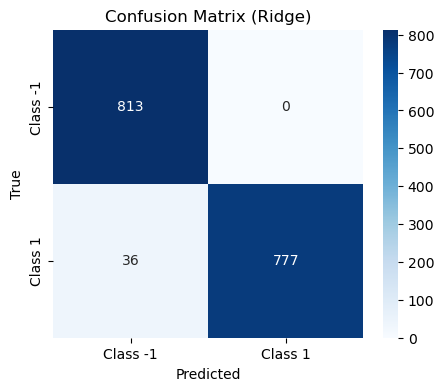

In [158]:
# 7. Построение матрицы разбиения (Confusion Matrix)
cm = confusion_matrix(y_test_class, test_predictions_1)

# Визуализация матрицы разбиения
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Class -1', 'Class 1'], yticklabels=['Class -1', 'Class 1'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix (Ridge)')
plt.show()

#### 2) Алгоритм линейной классификации на основе градиентного спуска

In [163]:
# Функции для вычисления рисков и градиентов

def hinge_loss(y, y_pred):
    return np.mean(np.maximum(0, 1 - y * y_pred))

def logistic_loss(y, y_pred):
    return np.mean(np.log(1 + np.exp(-y * y_pred)))

def quadratic_loss(y, y_pred):
    return np.mean((y - y_pred) ** 2)

def gradient_risk(beta, X, y, alpha, l1_ratio, risk_type):
    n = len(y)
    margin = y * (X @ beta)
    
    if risk_type == 'hinge_loss':
        risk = hinge_loss(y, margin)
        gradient = -X.T @ (y * (margin < 1)) / n  # Градиент хингевского риска
    elif risk_type == 'logistic_loss':
        risk = logistic_loss(y, margin)
        gradient = -X.T @ (y / (1 + np.exp(y * margin))) / n  # Градиент логистической потери
    elif risk_type == 'quadratic_loss':
        risk = quadratic_loss(y, margin)
        gradient = -2 * X.T @ (y - margin) / n  # Градиент квадратичной потери
    
    # Elastic Net регуляризация
    l1_penalty = l1_ratio * np.sign(beta)
    l2_penalty = (1 - l1_ratio) * beta
    regularization = alpha * (l1_penalty + l2_penalty)
    gradient += regularization
    
    return risk, gradient

# Функция для градиентного спуска
def gradient_descent(X, y, alpha, l1_ratio, num_iterations, learning_rate, risk_type):
    X = np.c_[np.ones(X.shape[0]), X]  # Добавляем единичный столбец для смещения (intercept)
    beta = np.zeros(X.shape[1])
    risks = []
    for i in range(num_iterations):
        risk, gradient = gradient_risk(beta, X, y, alpha, l1_ratio, risk_type)
        beta -= learning_rate * gradient
        risks.append(risk)
    return beta, risks

In [164]:
# Преобразуем целевой признак для классификации
df_gradient_descent = df.copy()
y_2 = pd.Series(np.where(df_gradient_descent['Package_quantity_pieces'].isin([0]), -1, 1))
X_2 = df_gradient_descent[df_gradient_descent.columns.difference(['Package_quantity_pieces'])]


# # Разделение на тренировочные и тестовые данные
X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(X_2, y_2, test_size=0.4, random_state=42)

# Параметры
num_folds = 5
num_iterations = 200

learning_rate_values = [0.1, 0.09, 0.08, 0.07, 0.06, 0.05, 0.01, 0.005, 0.001, 0.0001] #0.3, 0.25, 0.225, 0.2, 0.175, 0.15, 0.125, 
alpha_values = [10**(i * 0.1) for i in range(-20, 20)]  # Диапазон alpha для кросс-валидации
l1_ratio = 0.5  # Вес для L1 регуляризации (Elastic Net)
risk_types = ['hinge_loss', 'logistic_loss', 'quadratic_loss']

# KFold для кросс-валидации
kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)

best_alpha_2 = None
best_f1_score_2 = -float('inf')
best_learning_rate = None
best_beta_2 = None
best_risk_type = None

# Кросс-валидация и поиск лучших гиперпараметров
for alpha in alpha_values:
    for learning_rate in learning_rate_values: 
        for risk_type in risk_types:
            avg_f1_score = []
            
            for train_index, val_index in kf.split(X_train_2):
                X_train_fold, X_val_fold = X_train_2.iloc[train_index], X_train_2.iloc[val_index]
                y_train_fold, y_val_fold = y_train_2.iloc[train_index], y_train_2.iloc[val_index]
    
                # Выполнение градиентного спуска
                beta, train_risk = gradient_descent(X_train_fold, y_train_fold, alpha, l1_ratio, num_iterations, learning_rate, 'hinge_loss')
    
                # Прогнозирование для валидационного набора
                X_val_fold = np.c_[np.ones(X_val_fold.shape[0]), X_val_fold]  # Добавляем столбец единиц для валидационного набора
                y_pred_val = np.sign(X_val_fold @ beta) 
                
                # Вычисление F1-меры на валидационном наборе
                f1 = f1_score(y_val_fold, y_pred_val)
                avg_f1_score.append(f1)
            
            avg_f1_score_value = np.mean(avg_f1_score)
            
            if avg_f1_score_value > best_f1_score_2:
                best_f1_score_2 = avg_f1_score_value
                best_alpha_2 = alpha
                best_learning_rate = learning_rate
                best_beta_2 = beta
                best_risk_type = risk_type


print(f"Лучший параметр alpha: {best_alpha_2:.4f}")
print(f"Лучший коэффициент learning_rate: {best_learning_rate:.4f}")
# print(f"Лучший бета вектор: {best_beta_2}")
print(f"Лучший тип эмпирических рисков: {best_risk_type}")

# Прогнозирование для тестовой выборки с лучшей моделью
test_predictions_2 = np.sign(np.c_[np.ones(X_test_2.shape[0]), X_test_2].dot(best_beta_2))

# Оценка F1-меры на тестовом наборе
f1_test_2 = f1_score(y_test_2, test_predictions_2)
print(f"F1-меры на тестовом наборе: {f1_test_2:.4f}")

# Прогнозирование на тренировочной выборке с лучшей моделью
train_predictions_2 = np.sign(np.c_[np.ones(X_train_2.shape[0]), X_train_2].dot(best_beta_2))

# Оценка F1-меры на тренировочном наборе
f1_train_2 = f1_score(y_train_2, train_predictions_2)
print(f"F1-меры на тренировочном наборе: {f1_train_2:.4f}")

train_loss_2 = hinge_loss(y_train_2, train_predictions_2)
test_loss_2 = hinge_loss(y_test_2, test_predictions_2)

print(f"Empirical risk на тренировочной выборке: {train_loss_2:.4f}")
print(f"Empirical risk на тестовой выборке: {test_loss_2:.4f}")

Лучший параметр alpha: 0.0100
Лучший коэффициент learning_rate: 0.1000
Лучший тип эмпирических рисков: hinge_loss
F1-меры на тестовом наборе: 0.9774
F1-меры на тренировочном наборе: 0.9761
Empirical risk на тренировочной выборке: 0.0468
Empirical risk на тестовой выборке: 0.0443


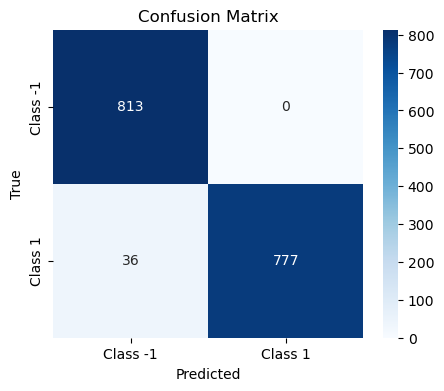

In [166]:
# Построение матрицы ошибок для модели с лучшими гиперпараметрами
cm_2 = confusion_matrix(y_test_2, test_predictions_2)
plt.figure(figsize=(5, 4))
sns.heatmap(cm_2, annot=True, fmt="d", cmap="Blues", xticklabels=['Class -1', 'Class 1'], yticklabels=['Class -1', 'Class 1'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

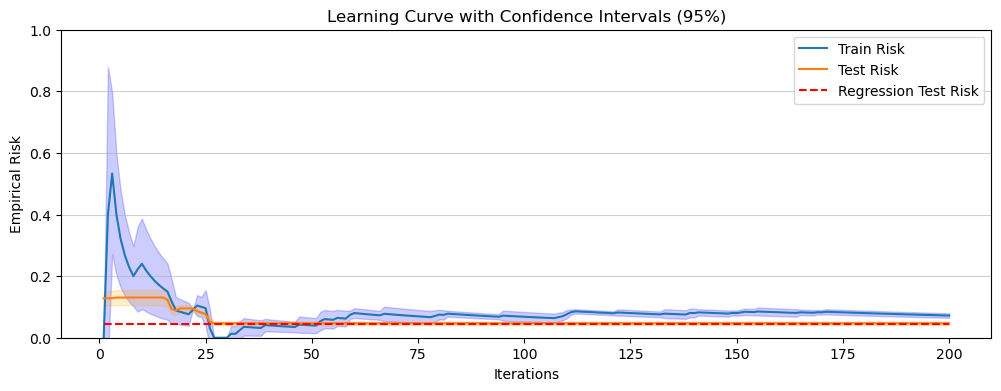

In [167]:
train_risks_per_split_2 = []
test_risks_per_split_2 = []

# Обучение и вычисление рисков
for train_index, val_index in kf.split(X_train_2):
    X_train_fold, X_val_fold = X_train_2.iloc[train_index], X_train_2.iloc[val_index]
    y_train_fold, y_val_fold = y_train_2.iloc[train_index], y_train_2.iloc[val_index]
    
    train_risks, test_risks = [], []
    
    for i in range(1, num_iterations + 1):
        beta, train_risk = gradient_descent(X_train_fold, y_train_fold, best_alpha_2, l1_ratio, i, best_learning_rate, best_risk_type)
        
        # Прогнозирование для тренировочной и тестовой выборки
        y_train_pred = np.c_[np.ones(X_train_fold[:i].shape[0]), X_train_fold[:i]] @ beta
        y_test_pred = np.c_[np.ones(X_val_fold.shape[0]), X_val_fold] @ beta

        # Вычисление эмпирического риска на тренировочной и тестовой выборках
        train_risk = hinge_loss(y_train_fold[:i], np.sign(y_train_pred))
        test_risk = hinge_loss(y_val_fold, np.sign(y_test_pred))
        
        train_risks.append(train_risk)
        test_risks.append(test_risk)
    
    train_risks_per_split_2.append(train_risks)
    test_risks_per_split_2.append(test_risks)

# Вычисление средних значений и доверительных интервалов
mean_train_risks_2 = np.mean(train_risks_per_split_2, axis=0)
mean_test_risks_2 = np.mean(test_risks_per_split_2, axis=0)
std_err_train_2 = sem(train_risks_per_split_2, axis=0)
std_err_test_2 = sem(test_risks_per_split_2, axis=0)

# Построение графиков с доверительным интервалом
plt.figure(figsize=(12, 4))

# Настройка осей
plt.ylim(0, 1)  # Установка пределов оси y
plt.yticks(np.arange(0, 1.1, 0.2))  # Установка шагов по оси y

# Для тренировочного эмпирического риска
plt.plot(range(1, num_iterations + 1), mean_train_risks_2, label="Train Risk")
plt.fill_between(
    range(1, num_iterations + 1),
    mean_train_risks_2 - 1.96 * std_err_train_2,
    mean_train_risks_2 + 1.96 * std_err_train_2,
    alpha=0.2,
    color="blue"
)

# Для тестового эмпирического риска
plt.plot(range(1, num_iterations + 1), mean_test_risks_2, label="Test Risk")
plt.fill_between(
    range(1, num_iterations + 1),
    mean_test_risks_2 - 1.96 * std_err_test_2,
    mean_test_risks_2 + 1.96 * std_err_test_2,
    alpha=0.2,
    color="orange"
)


# Линия для эмпирического риска линейной регрессии на тестовом множестве
test_loss_line_2 = [test_loss_2] * num_iterations
plt.plot(range(1, num_iterations + 1), test_loss_line_2, 'r--', label="Regression Test Risk")

plt.xlabel("Iterations")
plt.ylabel("Empirical Risk")
plt.legend()
plt.title("Learning Curve with Confidence Intervals (95%)")
plt.grid(axis='y', linestyle='-', alpha=0.6)
plt.show()


#### 3) Метод опорных векторов через градиентный спуск 

In [184]:
# Ядра
def linear_kernel(X, Y):
    return X @ Y.T

def polynomial_kernel(X, Y, degree=3):
    return (X @ Y.T + 1) ** degree

def rbf_kernel(X, Y, gamma=0.1):
    X = X.to_numpy() if isinstance(X, pd.DataFrame) else X
    Y = Y.to_numpy() if isinstance(Y, pd.DataFrame) else Y

    # Вычисляем расстояния и применяем RBF функцию
    sq_dists = np.sum(X**2, axis=1).reshape(-1, 1) + np.sum(Y**2, axis=1) - 2 * X @ Y.T
    return np.exp(-gamma * sq_dists)

In [186]:
# Целевая функция и её градиент
def dual_objective(alpha, K, y):
    y = y.to_numpy() if isinstance(y, pd.Series) else y
    alpha = np.asarray(alpha)
    return np.sum(alpha) - 0.5 * np.sum((alpha * y)[:, None] * (alpha * y)[None, :] * K)

def dual_gradient(alpha, K, y):
    y = y.to_numpy() if isinstance(y, pd.Series) else y
    alpha = np.asarray(alpha)
    return 1 - (K @ (alpha * y)) * y

# Градиентный спуск для SVM
def svm_gradient_descent_dual(X, y, C, kernel, num_iterations, learning_rate, kernel_params=None):
    X = np.asarray(X)
    y = np.asarray(y)
    n = len(y)
    alpha = np.zeros(n)
    K = None

    if kernel == 'linear':
        K = linear_kernel(X, X)
    elif kernel == 'polynomial':
        K = polynomial_kernel(X, X, degree=kernel_params.get('degree', 3))
    elif kernel == 'rbf':
        K = rbf_kernel(X, X, gamma=kernel_params.get('gamma', 0.1))
    else:
        raise ValueError("Unknown kernel")
    
    losses = []
    for i in range(num_iterations):
        grad = dual_gradient(alpha, K, y)
        alpha += learning_rate * grad
        # Восстанавливаем условия:
        alpha = np.clip(alpha, 0, C)
        sum_condition = np.dot(alpha, y)
        if sum_condition != 0:
            adjustment = sum_condition / np.sum(y != 0)
            alpha -= adjustment * y
        # Считаем значение целевой функции
        loss = dual_objective(alpha, K, y)
        losses.append(loss)
    
    return alpha, losses

def hinge_loss(y, y_pred):
    return np.mean(np.maximum(0, 1 - y * y_pred))

In [188]:
# Подготовка данных
y_3 = pd.Series(np.where(df['Package_quantity_pieces'].isin([0]), -1, 1))
X_3 = df[df.columns.difference(['Package_quantity_pieces'])]
X_train_3, X_test_3, y_train_3, y_test_3 = train_test_split(X_3, y_3, test_size=0.4, random_state=42)

# Гиперпараметры
num_iterations = 200
learning_rate_values = [10**x for x in range(-3, 1)]
C_values = [10**i for i in range(-5, 3)]
kernels = ['linear', 'polynomial', 'rbf']
gamma_values = gamma_values = [10**x for x in range(-3, 1)]
degree_values = [2, 3, 4] 

# KFold для кросс-валидации
kf_3 = KFold(n_splits=5, shuffle=True, random_state=42)
best_f1_score_3 = -float('inf')
best_hyperparams = None

In [195]:
# Перебор гиперпараметров
for kernel in kernels:
    for C in C_values:
        for learning_rate in learning_rate_values:
            for gamma in gamma_values if kernel == 'rbf' else [None]:  # Перебор gamma только для RBF
                for degree in degree_values if kernel == 'polynomial' else [None]:  # Перебор degree только для polynomial
                    avg_f1_score = []
                    kernel_params = {'degree': degree, 'gamma': gamma}  # Обновляем kernel_params
            
                    for train_index, val_index in kf_3.split(X_train_3):
                        X_train_fold, X_val_fold = X_train_3.iloc[train_index], X_train_3.iloc[val_index]
                        y_train_fold, y_val_fold = y_train_3.iloc[train_index], y_train_3.iloc[val_index]
                        X_train_fold = X_train_fold.to_numpy() if isinstance(X_train_fold, pd.DataFrame) else X_train_fold
                        y_train_fold = y_train_fold.to_numpy() if isinstance(y_train_fold, pd.Series) else y_train_fold
                        
                        alpha, _ = svm_gradient_descent_dual(X_train_fold, y_train_fold, C, kernel, num_iterations, learning_rate, kernel_params)
                        
                        # Вычисляем ядро для валидационного набора
                        if kernel == 'linear':
                            K_val = linear_kernel(X_val_fold, X_train_fold)
                        elif kernel == 'polynomial':
                            K_val = polynomial_kernel(X_val_fold, X_train_fold, degree=kernel_params['degree'])
                        elif kernel == 'rbf':
                            K_val = rbf_kernel(X_val_fold, X_train_fold, gamma=kernel_params['gamma'])
                        
                        # Предсказания и оценка
                        y_val_pred = np.sign(K_val @ (alpha * y_train_fold))
                        f1 = f1_score(y_val_fold, y_val_pred)
                        avg_f1_score.append(f1)
                    
                    avg_f1 = np.mean(avg_f1_score)
                    if avg_f1 > best_f1_score_3:
                        best_f1_score_3 = avg_f1
                        best_hyperparams = (kernel, C, learning_rate, gamma, degree)

# Лучшие гиперпараметры
print(f"Лучшие гиперпараметры: kernel - {best_hyperparams[0]}, C - {best_hyperparams[1]:.2f}, "
      f"learning_rate - {best_hyperparams[2]}, gamma - {best_hyperparams[3]}, degree - {best_hyperparams[4]}")
print(f"Лучший F1 Score (валидация): {best_f1_score_3:.4f}")

Лучшие гиперпараметры: kernel - rbf, C - 1.00, learning_rate - 0.001, gamma - 1, degree - None
Лучший F1 Score (валидация): 1.0000


In [200]:
# Итоговая модель на лучшей конфигурации
best_kernel_3, best_C_3, best_lr_3, best_gamma_3, best_degree_3 = best_hyperparams
kernel_params = {'degree': best_degree_3, 'gamma': best_gamma_3}

final_alpha, train_losses = svm_gradient_descent_dual(X_train_3, y_train_3, best_C_3, best_kernel_3, num_iterations, best_lr_3, kernel_params)

# Оценка на тестовой выборке
if best_kernel_3 == 'linear':
    K_test = linear_kernel(X_test_3, X_train_3)
elif best_kernel_3 == 'polynomial':
    K_test = polynomial_kernel(X_test_3, X_train_3, degree=kernel_params['degree'])
elif best_kernel_3 == 'rbf':
    K_test = rbf_kernel(X_test_3, X_train_3, gamma=kernel_params['gamma'])

test_predictions_3 = np.sign(K_test @ (final_alpha * y_train_3))
f1_test_3 = f1_score(y_test_3, test_predictions_3)
print(f"F1 Score на тестовой выборке: {f1_test_3:.4f}")

# Оценка на тренировочной выборке
if best_kernel_3 == 'linear':
    K_train = linear_kernel(X_train_3, X_train_3)
elif best_kernel_3 == 'polynomial':
    K_train = polynomial_kernel(X_train_3, X_train_3, degree=kernel_params['degree'])
elif best_kernel_3 == 'rbf':
    K_train = rbf_kernel(X_train_3, X_train_3, gamma=kernel_params['gamma'])

train_predictions_3 = np.sign(K_train @ (final_alpha * y_train_3))
f1_train_3 = f1_score(y_train_3, train_predictions_3)
print(f"F1 Score на тренировочной выборке: {f1_train_3:.4f}")

train_loss_3 = hinge_loss(y_train_3, train_predictions_3)
test_loss_3 = hinge_loss(y_test_3, test_predictions_3)

print(f"Empirical risk на тренировочной выборке: {train_loss_3:.4f}")
print(f"Empirical risk на тестовой выборке: {test_loss_3:.4f}")

F1 Score на тестовой выборке: 1.0000
F1 Score на тренировочной выборке: 1.0000
Empirical risk на тренировочной выборке: 0.0000
Empirical risk на тестовой выборке: 0.0000


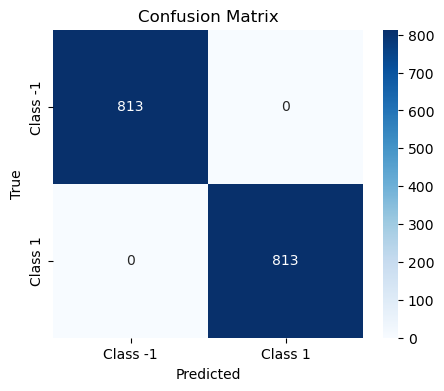

In [202]:
# Построение матрицы ошибок для модели с лучшими гиперпараметрами
cm_3 = confusion_matrix(y_test_3, test_predictions_3)
plt.figure(figsize=(5, 4))
sns.heatmap(cm_3, annot=True, fmt="d", cmap="Blues", xticklabels=['Class -1', 'Class 1'], yticklabels=['Class -1', 'Class 1'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

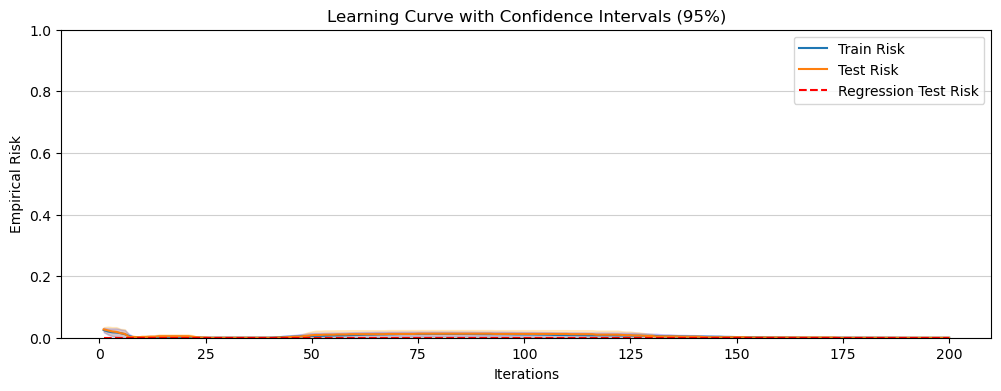

In [206]:
train_risks_per_split_3 = []
test_risks_per_split_3 = []

# Обучение и вычисление рисков
for train_index, val_index in kf.split(X_train_3):
    X_train_fold, X_val_fold = X_train_3.iloc[train_index], X_train_3.iloc[val_index]
    y_train_fold, y_val_fold = y_train_3.iloc[train_index], y_train_3.iloc[val_index]
    
    train_losses, test_losses = [], []
    
    for i in range(1, num_iterations + 1):
        alpha, _ = svm_gradient_descent_dual(X_train_fold, y_train_fold, best_C_3, best_kernel_3, i, best_lr_3, kernel_params)

        # Прогнозирование для тренировочной выборки
        if best_kernel_3 == 'linear':
            K_train = linear_kernel(X_train_fold, X_train_fold)
        elif best_kernel_3 == 'polynomial':
            K_train = polynomial_kernel(X_train_fold, X_train_fold, degree=kernel_params['degree'])
        elif best_kernel_3 == 'rbf':
            K_train = rbf_kernel(X_train_fold, X_train_fold, gamma=kernel_params['gamma'])
        
        y_train_pred = np.sign(K_train @ (alpha * y_train_fold))  # Предсказания для тренировки

        # Прогнозирование для тестовой выборки
        if best_kernel_3 == 'linear':
            K_val = linear_kernel(X_val_fold, X_train_fold)
        elif best_kernel_3 == 'polynomial':
            K_val = polynomial_kernel(X_val_fold, X_train_fold, degree=kernel_params['degree'])
        elif best_kernel_3 == 'rbf':
            K_val = rbf_kernel(X_val_fold, X_train_fold, gamma=kernel_params['gamma'])
        
        y_test_pred = np.sign(K_val @ (alpha * y_train_fold))  # Предсказания для теста

        # Вычисление потерь на тренировочной и тестовой выборках
        train_loss = hinge_loss(y_train_fold, y_train_pred)
        test_loss = hinge_loss(y_val_fold, y_test_pred)

        train_losses.append(train_loss)
        test_losses.append(test_loss)
    
    train_risks_per_split_3.append(train_losses)
    test_risks_per_split_3.append(test_losses)

# Вычисление средних значений и доверительных интервалов
mean_train_risks_3 = np.mean(train_risks_per_split_3, axis=0)
mean_test_risks_3 = np.mean(test_risks_per_split_3, axis=0)
std_err_train_3 = sem(train_risks_per_split_3, axis=0)
std_err_test_3 = sem(test_risks_per_split_3, axis=0)

# Построение графиков с доверительным интервалом
plt.figure(figsize=(12, 4))

# Настройка осей
plt.ylim(0, 1)  # Установка пределов оси y
plt.yticks(np.arange(0, 1.1, 0.2))  # Установка шагов по оси y

# Для тренировочного эмпирического риска
plt.plot(range(1, num_iterations + 1), mean_train_risks_3, label="Train Risk")
plt.fill_between(
    range(1, num_iterations + 1),
    mean_train_risks_3 - 1.96 * std_err_train_3,
    mean_train_risks_3 + 1.96 * std_err_train_3,
    alpha=0.2,
    color="blue"
)

# Для тестового эмпирического риска
plt.plot(range(1, num_iterations + 1), mean_test_risks_3, label="Test Risk")
plt.fill_between(
    range(1, num_iterations + 1),
    mean_test_risks_3 - 1.96 * std_err_test_3,
    mean_test_risks_3 + 1.96 * std_err_test_3,
    alpha=0.2,
    color="orange"
)

# Линия для эмпирического риска линейной регрессии на тестовом множестве
test_loss_line_3 = [test_loss_3] * num_iterations
plt.plot(range(1, num_iterations + 1), test_loss_line_3, 'r--', label="Regression Test Risk")

plt.xlabel("Iterations")
plt.ylabel("Empirical Risk")
plt.legend()
plt.title("Learning Curve with Confidence Intervals (95%)")
plt.grid(axis='y', linestyle='-', alpha=0.6)
plt.show()